In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import squidpy as sq
import numpy as np
from PIL import Image
import networkx as nx

import ncem

usr = !echo $USER
datadir = '.'

# Load data

In [2]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_path=datadir + 'zhang/',
    data_origin="zhang",
    radius=100,
    node_label_space_id='type',
    node_feature_space_id='standard'
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata
collecting image-wise celldata


  5%|▍         | 3/64 [00:00<00:02, 22.88it/s]

adding graph-level covariates


100%|██████████| 64/64 [00:03<00:00, 19.77it/s]


Loaded 64 images with complete data from 2 patients over 280327 cells with 254 cell features and 25 distinct celltypes.
Mean of mean node degree per images across images: 40.670611

 Celldata metadata: {'lateral_resolution': 0.109, 'fn': 'preprocessed_zhang.h5ad', 'image_col': 'slice_id', 'pos_cols': ['center_x', 'center_y'], 'cluster_col': 'subclass', 'cluster_col_preprocessed': 'subclass_preprocessed', 'patient_col': 'mouse'}


# Supp. Fig. 1: Cell-type centric summary statistics in MERFISH - brain dataset. 

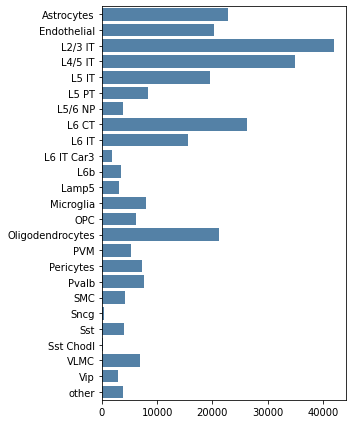

In [3]:
interpreter.data.celltype_frequencies()

0.0
1.2209650177678366
3.373137122402878
11.314344869057322
41.67061117031619
235.36600106608932
810.8033113749502
2334.0417190338585
4380.109375


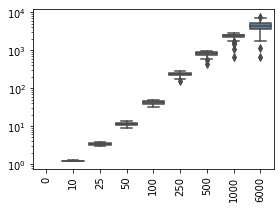

In [4]:
interpreter.data.plot_degree_vs_dist(
    max_distances=[0, 10, 25, 50, 100, 250, 500, 1000, 6000 ],
    lateral_resolution=1,
)

# Figure 1: Modeling cell communication as spatial cell state dependencies.

         Falling back to preprocessing with `sc.pp.pca` and default params.


n cells:  7439


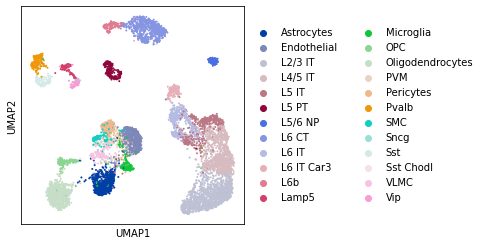

In [5]:
adata = interpreter.data.umap(
    image_key= "mouse1_slice153",
    undefined_type='other',
    n_neighbors=10,
    n_pcs=35,
)

Trying to set attribute `.uns` of view, copying.


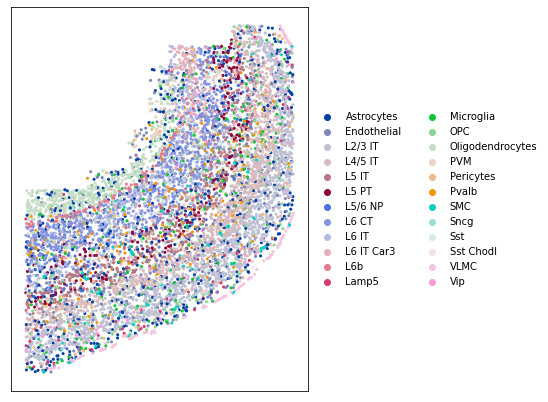

In [6]:
adata = interpreter.data.spatial(
    image_key= "mouse1_slice153",
    undefined_type='other',
    #panel_width=5,
    #panel_height=5,
    #fontsize=12,
    clean_view=True,
    copy=True
)

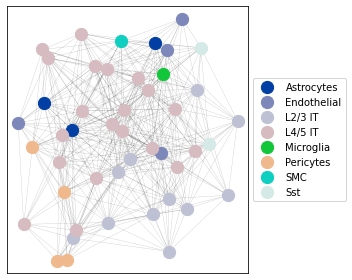

In [7]:
figsize = (5., 4.)
edge_width = 0.3

dataset1_sample3_486 = adata[adata.obs['fovID'] == 486]
dataset1_sample3_486.obsm['spatial'] = dataset1_sample3_486.obsm['spatial']/interpreter.data.celldata.uns['metadata']['lateral_resolution']

h_0 = dataset1_sample3_486.obsm["node_types"]
a = dataset1_sample3_486.obsp["adjacency_matrix_connectivities"]
cell_types = dataset1_sample3_486.obs["subclass_preprocessed"]
if cell_types is None:
    raise ValueError('No cell types for this image available')
# Mask cell types like data batch:
cell_types = cell_types[np.arange(0, a.shape[0])]

cell_type_names = dataset1_sample3_486.uns['node_type_names']

g = nx.from_numpy_matrix(a.todense())
# Include masking of data batch by using h shape:
dict_nodes = {i: np.array(dataset1_sample3_486.obsm["spatial"])[i] for i in np.arange(h_0.shape[0])}

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
nx.draw_networkx_edges(
    g,
    pos=dict_nodes,
    width=edge_width,
    alpha=0.25
)

for i, ctype in enumerate(np.unique(cell_types)):
    # print(ctype)
    #color = [zeileis_28[cell_type_names[ctype]]]
    idx_c = list(np.where(cell_types == ctype)[0])
    nx.draw_networkx_nodes(
        g,
        # with_labels=False,
        node_size=150,
        nodelist=idx_c,
        node_color=dataset1_sample3_486.uns['subclass_preprocessed_colors'][i],
        pos=dict_nodes,
        label=cell_type_names[ctype].replace(
            '_', ' '
        )
    )
box = ax.get_position()
ax.invert_yaxis()
ax.set_position([box.x0, box.y0, box.width, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

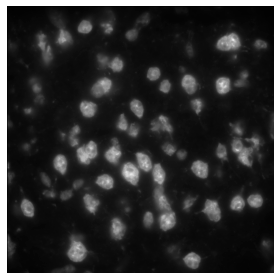

In [8]:
fn = f"{datadir}zhang/processed_images486.tif"
img = Image.open(fn)
images = []
for i in range(img.n_frames):
    img.seek(i)
    images.append(np.array(img))
img.close()

images = np.array(images)
images = np.transpose(images, (1, 2, 0))

# readoutName polyT are in frames [154:160] with zPos (µm) [0.  1.5 3.  4.5 6.  7.5 9. ]
# we show the center z-plane at z=4.5µm
img = sq.im.ImageContainer(images[:, :, 157])
sq.im.process(img)
img.show('image_smooth', cmap="Greys_r", figsize=(4,4))

# Figure 2: Attributing cell heterogeneity to niche composition.

         Falling back to preprocessing with `sc.pp.pca` and default params.


n cells:  1204
L2/3 IT 0    316
L2/3 IT 1    314
L2/3 IT 2    313
L2/3 IT 3    133
L2/3 IT 4    128
Name: L2/3 IT substates, dtype: int64


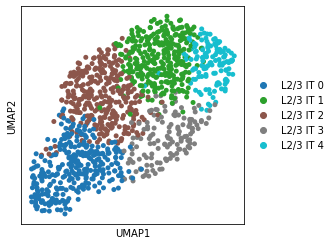

In [9]:
adata = interpreter.data.umap(
    image_key= "mouse1_slice153",
    target_cell_type='L2/3 IT',
    n_neighbors=40,
    n_pcs=40,
    palette='tab10'
)

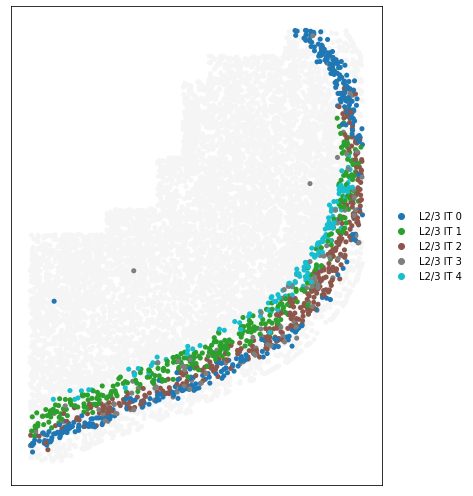

In [10]:
interpreter.data.spatial_substates(
    adata,
    image_key= "mouse1_slice153",
    target_cell_type='L2/3 IT',
    clean_view=True
)

In [11]:
filter_titles = [
    'Oligodendrocytes',
    'Pvalb',
    'L4/5 IT',
    'Sncg',
    'Lamp5',
    'Vip',
    'L5/6 NP',
    'VLMC',
    'L6 IT Car3',
    'Microglia',
    'Endothelial',
    'L5 IT',
    'Sst',
    'OPC',
    'Astrocytes',
    'L2/3 IT',
    'Sst Chodl',
    'Pericytes',
    'SMC',
    'PVM'
]

adata_img, adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key=['mouse1_slice153'],
    target_cell_type='L2/3 IT',
    undefined_type='other',
    clip_pvalues=-5,
    filter_titles=filter_titles,
    n_neighbors=40,
    n_pcs=40
)

 83%|████████▎ | 127/153 [00:53<00:10,  2.53it/s]WARNING: You’re trying to run this on 254 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
100%|██████████| 153/153 [01:02<00:00,  2.44it/s]


n cells:  1204
L2/3 IT 0    316
L2/3 IT 1    314
L2/3 IT 2    313
L2/3 IT 3    133
L2/3 IT 4    128
Name: L2/3 IT substates, dtype: int64


... storing 'slice_id' as categorical
... storing 'sample_id' as categorical
... storing 'label' as categorical
... storing 'subclass' as categorical
... storing 'mouse' as categorical
... storing 'slice' as categorical
... storing 'dataset' as categorical
... storing 'sample' as categorical
... storing 'subclass_preprocessed' as categorical
... storing 'source type L6 CT' as categorical
... storing 'source type L6 IT Car3' as categorical
... storing 'source type L6b' as categorical
... storing 'source type Sncg' as categorical
... storing 'source type Sst Chodl' as categorical
... storing 'source type other' as categorical


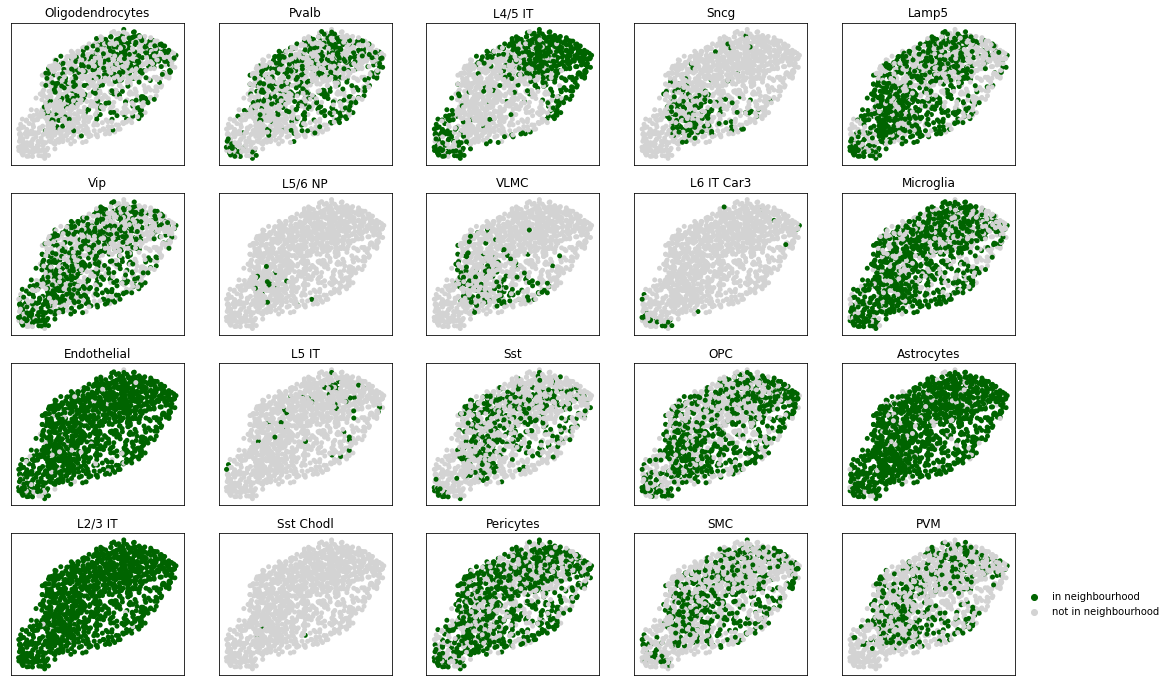

In [12]:
interpreter.data.umaps_cluster_enrichment(adata, filter_titles)

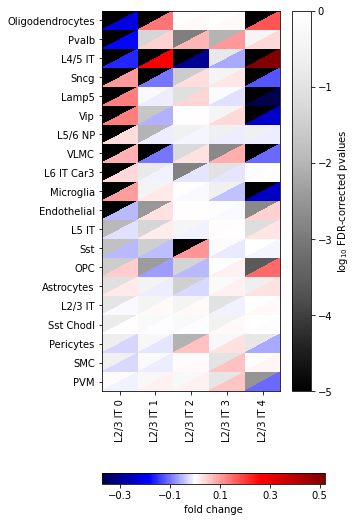

In [13]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    #fontsize=14,
    linspace=(-0.3, 0.5, 5)
)

# Supp. Fig. 2: Variance decomposition in spatial omics data sets.

In [14]:
var_decomp = interpreter.data.compute_variance_decomposition(undefined_type='other')

100%|██████████| 64/64 [07:00<00:00,  6.57s/it]


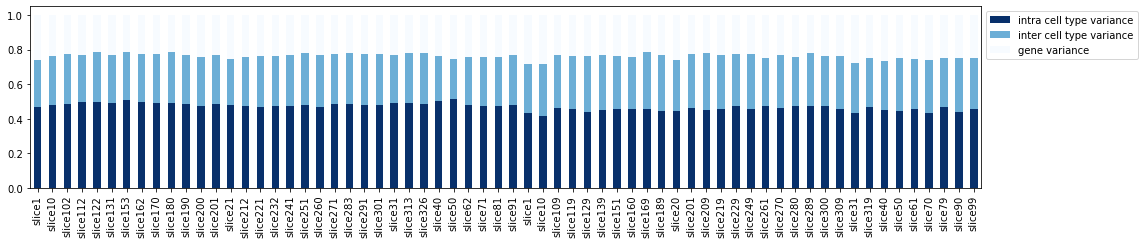

In [15]:
interpreter.data.variance_decomposition(var_decomp, multiindex=True)

In [16]:
var_decomp.mean(axis=0)[['intra cell type variance', 'inter cell type variance', 'gene variance']]

intra cell type variance    0.470461
inter cell type variance    0.292520
gene variance               0.237020
dtype: float32

# Supp. Fig. 5: Attribution of molecular states to neighborhoods in the MERFISH – brain data set.

         Falling back to preprocessing with `sc.pp.pca` and default params.


n cells:  946
L2/3 IT 0    226
L2/3 IT 1    209
L2/3 IT 2    193
L2/3 IT 3    191
L2/3 IT 4    127
Name: L2/3 IT substates, dtype: int64


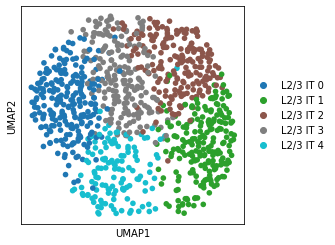

In [17]:
adata = interpreter.data.umap(
    image_key= "mouse1_slice162",
    target_cell_type='L2/3 IT',
    n_neighbors=40,
    n_pcs=40,
    palette='tab10'
)

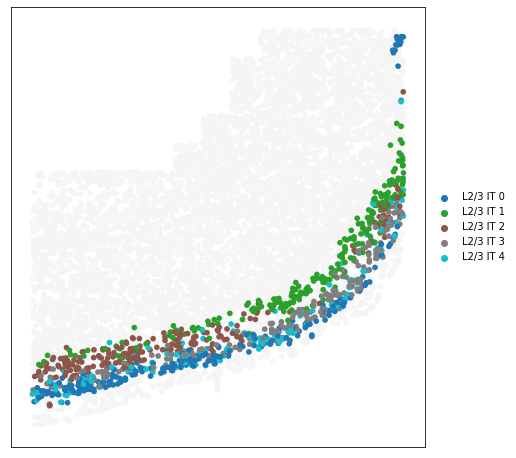

In [18]:
interpreter.data.spatial_substates(
    adata,
    image_key= "mouse1_slice162",
    target_cell_type='L2/3 IT',
)

In [19]:
filter_titles = ['L4/5 IT',
 'VLMC',
 'Pvalb',
 'Sncg',
 'Sst Chodl',
 'SMC',
 'Astrocytes',
 'Lamp5',
 'PVM',
 'L5 IT',
 'Oligodendrocytes',
 'L6 IT',
 'L2/3 IT',
 'Endothelial',
 'Sst',
 'OPC',
 'L6b',
 'Vip',
 'Microglia',
 'Pericytes'
]

adata_img, adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key=['mouse1_slice162'],
    target_cell_type='L2/3 IT',
    undefined_type='other',
    clip_pvalues=-5,
    n_neighbors=40,
    n_pcs=40,
    filter_titles=filter_titles
)

 83%|████████▎ | 127/153 [03:35<00:59,  2.27s/it]WARNING: You’re trying to run this on 254 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
100%|██████████| 153/153 [04:28<00:00,  1.75s/it]


n cells:  946
L2/3 IT 0    226
L2/3 IT 1    209
L2/3 IT 2    193
L2/3 IT 3    191
L2/3 IT 4    127
Name: L2/3 IT substates, dtype: int64


... storing 'slice_id' as categorical
... storing 'sample_id' as categorical
... storing 'label' as categorical
... storing 'subclass' as categorical
... storing 'mouse' as categorical
... storing 'slice' as categorical
... storing 'dataset' as categorical
... storing 'sample' as categorical
... storing 'subclass_preprocessed' as categorical
... storing 'source type L6 CT' as categorical
... storing 'source type L6 IT Car3' as categorical
... storing 'source type L6b' as categorical
... storing 'source type Sncg' as categorical
... storing 'source type Sst Chodl' as categorical
... storing 'source type other' as categorical


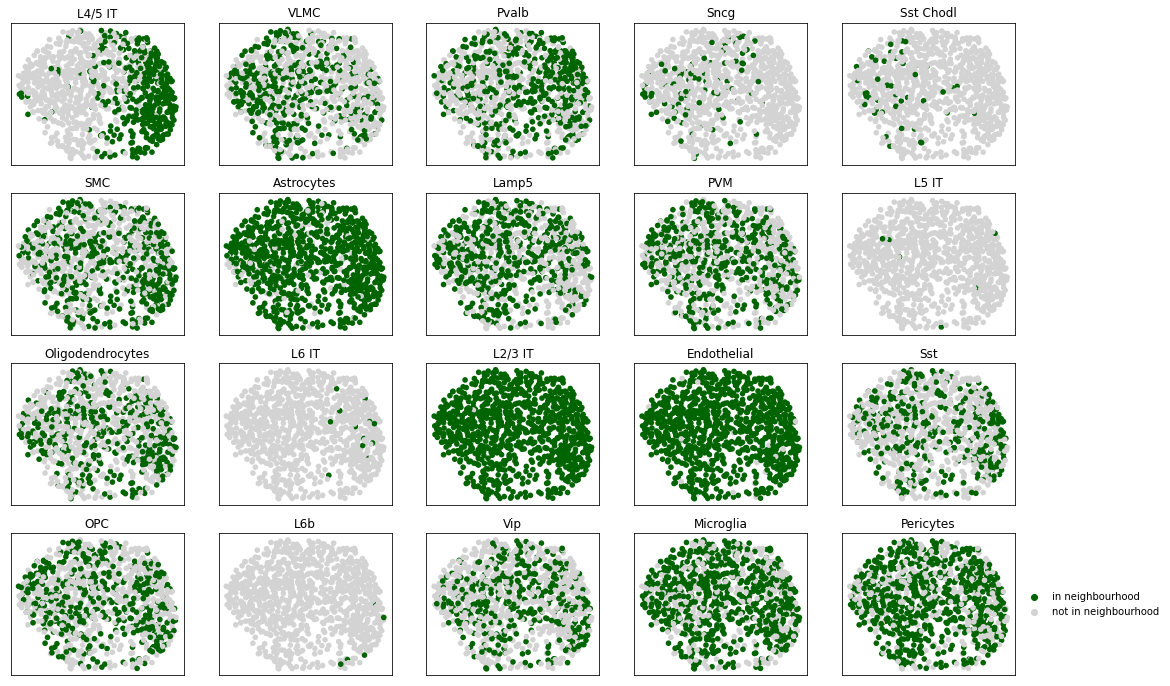

In [20]:
interpreter.data.umaps_cluster_enrichment(adata, filter_titles)

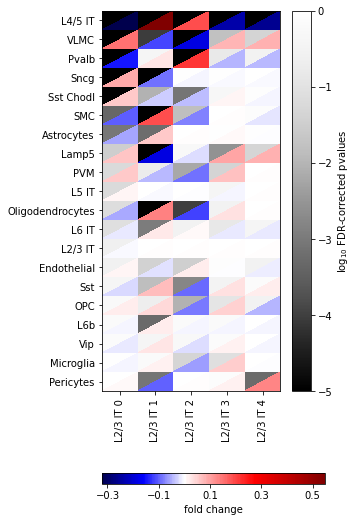

In [21]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    linspace=(-0.3, 0.5, 5)
)

# Supp. Fig. 6: Normalised contact frequencies of cell-types in spatial neighborhoods

100%|██████████| 64/64 [09:01<00:00,  8.46s/it]


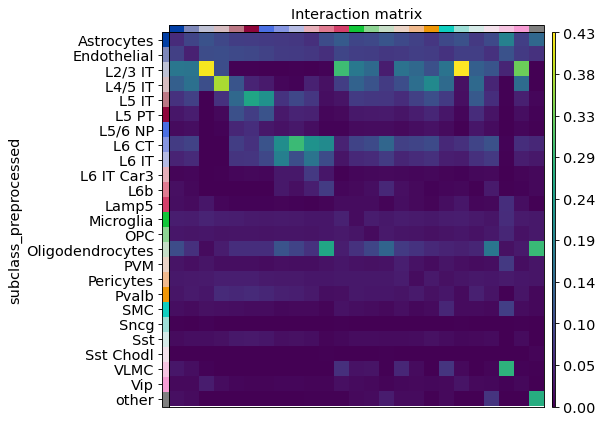

In [22]:
interpreter.data.celldata_interaction_matrix()

# Supp. Fig. 7: Ligand–receptor permutation test.

n cells: 27638


  0%|          | 0/1000 [00:00<?, ?permutation/s]

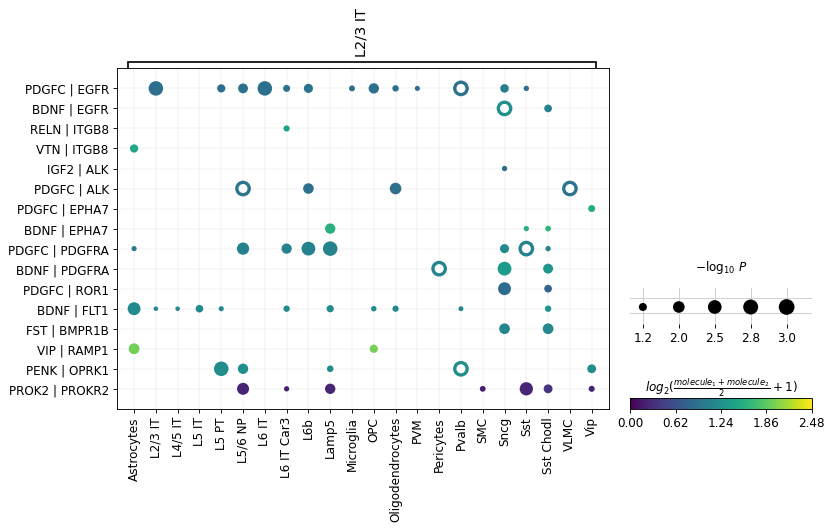

In [23]:
adata = interpreter.data.ligrec(
    fraction=0.1,
    source_groups='L2/3 IT',
    undefined_type='other',
)

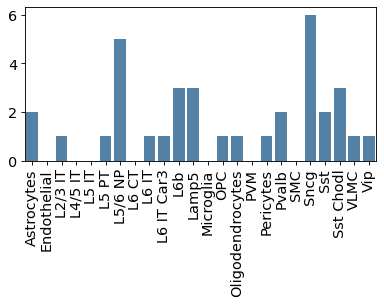

In [24]:
interpreter.data.ligrec_barplot(
    adata,
    source_group='L2/3 IT',
)

n cells: 7439


  0%|          | 0/1000 [00:00<?, ?permutation/s]

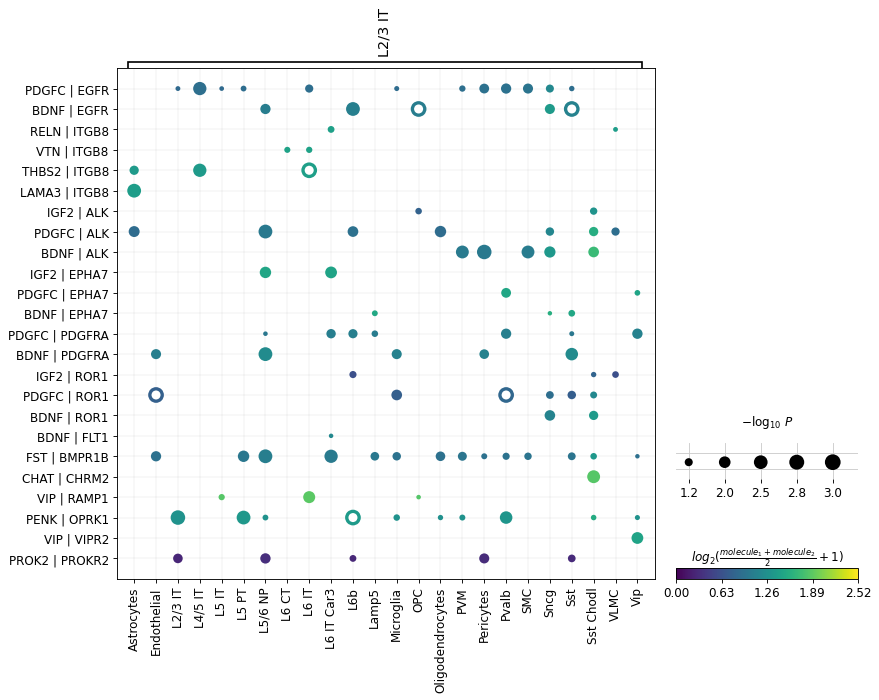

In [25]:
adata = interpreter.data.ligrec(
    image_key= "mouse1_slice153",
    source_groups='L2/3 IT',
    undefined_type='other',
)

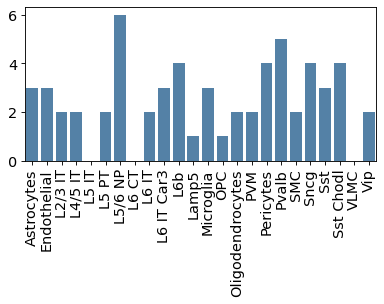

In [26]:
interpreter.data.ligrec_barplot(
    adata,
    source_group='L2/3 IT',
)

# Supp. Fig. 13: Distributional characteristics of gene expression measurements of single cells from spatial molecular profiling assays.

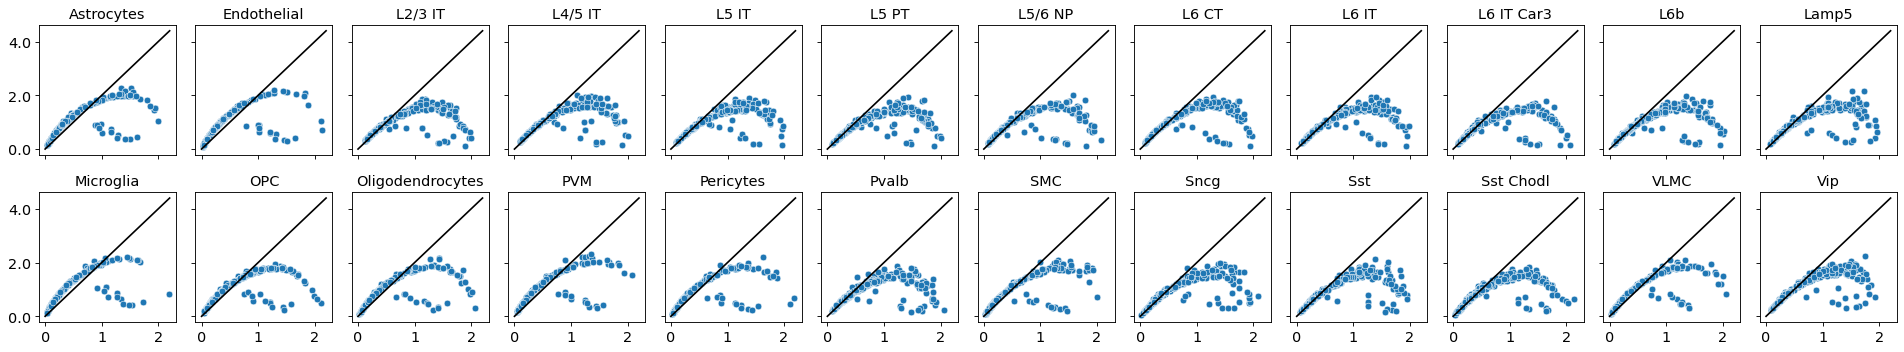

In [27]:
interpreter.data.noise_structure(undefined_type='other', min_x=0.0, max_x=2.2)